<a href="https://colab.research.google.com/github/ihagoSantos/special-topics-in-machine-learning/blob/main/04_Autoencoders%2C_GANs%2C_e_Diffusion_Models_projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Verifique se existe uma GPU disponível

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

**Projeto**

Projeto: tente usar um autoencoder de eliminação de ruído para pré-treinar um classificador de imagem. Você pode usar MNIST (a opção mais simples) ou um conjunto de dados de imagens mais complexo como [CIFAR10](https://homl.info/122).

Independentemente do conjunto de dados que você está usando, siga estas etapas:_
* Divida o conjunto de dados em um conjunto de treinamento e um conjunto de teste. Treine um autoencoder com eliminação de ruído no conjunto de treinamento.


In [6]:
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(28, 1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

In [8]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(14 * 14 * 28, activation="relu"),
    tf.keras.layers.Reshape([14, 14, 28]),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [10]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.1675 - mse: 0.0352 - val_loss: 0.0796 - val_mse: 0.0060
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0810 - mse: 0.0064 - val_loss: 0.0760 - val_mse: 0.0048
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0782 - mse: 0.0056 - val_loss: 0.0747 - val_mse: 0.0044
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0771 - mse: 0.0052 - val_loss: 0.0741 - val_mse: 0.0042
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0765 - mse: 0.0050 - val_loss: 0.0737 - val_mse: 0.0041
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0761 - mse: 0.0049 - val_loss: 0.0734 - val_mse: 0.0040
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0757 - mse: 0.0048 - val_loss: 0.0730 - val_mse: 0.0039
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0754 - mse: 0.0047 - val_loss: 0.0729 - val_mse: 0.0038
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


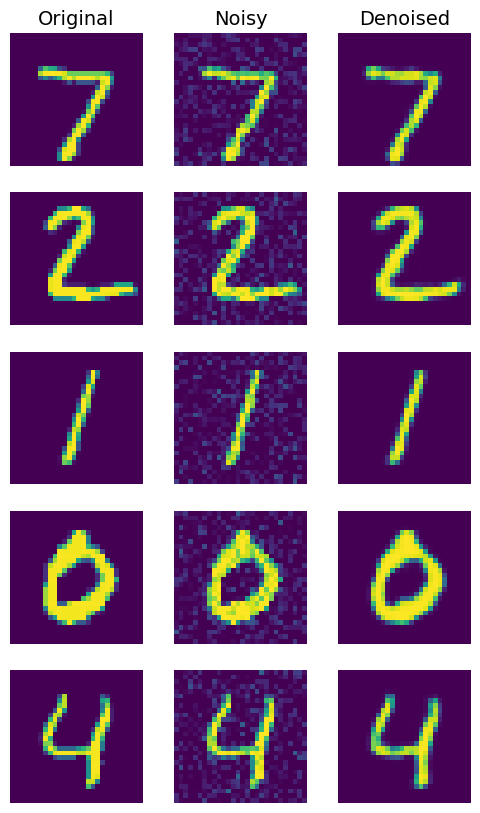

In [11]:
import numpy as np

n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 28, 28, 1) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()